In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA

from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# import functions.py
from functions import _preprocess_X, TSNE_reduction, UMAP_reduction, HVGs

# Loading data

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [3]:
# convert to array
X_train = X_train.toarray()
X_train

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Data Preprocession

**Normalization data using highly deviance genes**

In [4]:
# X normalization 
X_bd_train, y_bd_train= _preprocess_X(X_train, y_train, quality_control=True)

<AxesSubplot: ylabel='Density'>

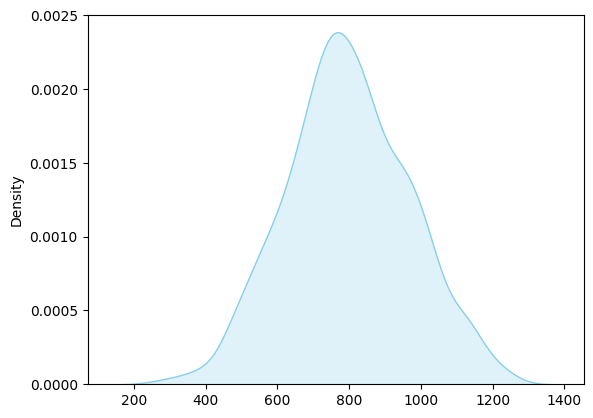

In [5]:
sns.kdeplot(X_bd_train.sum(axis=1), color='skyblue', fill=True)

In [6]:
ind = HVGs(X_bd_train, top_proportion=0.2, num_genes=None)
X_bd_train = X_bd_train[:, ind]

In [7]:
scaler = StandardScaler()
X_bd_train = scaler.fit_transform(X_bd_train)

In [ ]:
# init PCA with 50 components
pca = PCA(n_components=50)
# compute PCA
X_bd_train = pca.fit_transform(X_bd_train)

**Normalization using highly variable genes**

### GridSearchCV

In [9]:
# Function to do grid search 
def grid_cv(params_grid, model, X, y, k):
    grid_search = GridSearchCV(model, params_grid, scoring='balanced_accuracy', cv=k, n_jobs=-1, refit=True)
    grid_search.fit(X, y)

    best_params = grid_search.cv_results_['params'][grid_search.best_index_]
    best_score = grid_search.best_score_
    print('The best hyper-parameters are {0}, with accuracy = {1}.'.format(best_params, best_score))

**LightGBM**

In [11]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [12]:
params = {'learning_rate': np.linspace(0.1, 1, 10),
          'num_leaves':[31],
          'max_depth' :[-1, 5]}

lgbm = LGBMClassifier(random_state=42)
grid_cv(params, lgbm, X_bd_train, y_bd_train, 5)

The best hyper-parameters are {'learning_rate': 0.6, 'max_depth': 5, 'num_leaves': 31}, with accuracy = 0.8621646642004139.


In [ ]:
params = {'learning_rate':[0.1, 0.01],
          'num_leaves':[15, 31],
          'max_depth' :[-1, 4, 5],
          'min_data_in_leaf':[20, 25]}

lgbm = LGBMClassifier()
grid_cv(params, lgbm, X_bd_train, y_bd_train, 4)

**Gradient Boosting**

In [13]:
params = {"learning_rate": [0.01, 0.1],
          "min_samples_split": [0.8, 2],
          "min_samples_leaf": [0.5, 1],
          "max_depth":[3,5,8],
          "max_features":["log2","sqrt", None]}

gb_clf = GradientBoostingClassifier(random_state=42)
grid_cv(params, gb_clf, X_bd_train, y_bd_train, 4)

The best hyper-parameters are {'learning_rate': 0.1, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, with accuracy = 0.8202659044963675.


In [ ]:
params = {"learning_rate": [0.01, 0.1],
          "min_samples_split": [0.8, 1],
          "min_samples_leaf": [0.1, 0.5, 1],
          "max_depth":[3,5,8],
          "max_features":["log2","sqrt", None],
          "n_estimators":[10, 100]}

gb_clf = GradientBoostingClassifier(random_state=42)
grid_cv(params, gb_clf, X_bd_train, y_bd_train, 4)

**Logistic Regression**

In [14]:
params = {'C': np.linspace(0.1, 3, 30),
          'penalty': [None, 'l1', 'l2', 'elasticnet']}

logistic = LogisticRegression(solver='saga', tol=1e-2, random_state=42)
grid_cv(params, logistic, X_bd_train, y_bd_train, 5)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "c:\Users\Admin\AppD

The best hyper-parameters are {'C': 1.9, 'penalty': 'l1'}, with accuracy = 0.8677571205873094.


**MLP**

In [15]:
params = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['lbfgs', 'sgd', 'adam'],
          'learning_rate':['constant', 'invscaling', 'adaptive']}

mlp = MLPClassifier(random_state=42)
grid_cv(params, mlp, X_bd_train, y_bd_train, 5)

The best hyper-parameters are {'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'lbfgs'}, with accuracy = 0.8593858254732136.


Stacking

In [10]:
estimators = [
            ('mlp', MLPClassifier(random_state=42)),
            ('OVR_lgbm', OneVsRestClassifier(LGBMClassifier())),
            ('lgbm', LGBMClassifier())
        ]
sclf = StackingClassifier(estimators= estimators , final_estimator=make_pipeline(StandardScaler(), LogisticRegression()))

params = {'mlp__learning_rate_init': [1e-2, 0.1],
          'mlp__early_stopping': [False, True],
          'lgbm__learning_rate': [1e-2, 0.1, 0.5]}

grid_cv(params, sclf, X_bd_train, y_bd_train, 5)

In [13]:
from sklearn.pipeline import make_pipeline
estimators = [
            ('ridge', RidgeClassifier(random_state=42)),
            ('sgd', SGDClassifier(random_state=42)),
            ('mlp', make_pipeline(
                StandardScaler(),
                MLPClassifier(random_state=42)
            )),
            ('xrf', ExtraTreesClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42)),
            ('lgbm', LGBMClassifier(
                learning_rate=0.5, verbose=-100, n_jobs=-1))
        ]
sclf = StackingClassifier(estimators=estimators, final_estimator=make_pipeline(StandardScaler(), LogisticRegression()))

params = {'gb__n_estimators': [400, 1000],
          'gb__learning_rate': [0.01, 0.1],
          'gb__max_features': ['log2']}

grid_cv(params, sclf, X_bd_train, y_bd_train, 5)

The best hyper-parameters are {'gb__learning_rate': 0.1, 'gb__max_features': 'log2', 'gb__n_estimators': 400}, with accuracy = 0.8720202319025658.


In [14]:
from sklearn.pipeline import make_pipeline
estimators = [('gb', GradientBoostingClassifier()),
              ('mlp', MLPClassifier(random_state=42)),
              ('lgbm', LGBMClassifier())]

sclf_1 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

params = {'gb__n_estimators': [700, 800, 900, 1000],
          'gb__learning_rate': [0.01, 0.1],
          'gb__max_features':['log2']}

grid_cv(params, sclf_1, X_bd_train, y_bd_train, 3)

The best hyper-parameters are {'gb__learning_rate': 0.01, 'gb__max_features': 'log2', 'gb__n_estimators': 1000}, with accuracy = 0.8454136278579066.
